# Zeisel GRN Inference and Analysis

## 0. Import dependencies

In [1]:
import os
import sys
sys.path.append('../../')

from arboreto.core import *
from arboreto.utils import *

import matplotlib.pyplot as plt

## 1. Load the data (outside the scope of the arboreto API)

In [2]:
zeisel_ex_path = '/media/tmo/data/work/datasets/zeisel/expression_sara_filtered.txt'
zeisel_tf_path = '/media/tmo/data/work/datasets/TF/mm9_TFs.txt'

In [3]:
zeisel_df = pd.read_csv(zeisel_ex_path, index_col=0, sep='\t').T
zeisel_df.head()

,Tspan12,Tshz1,Fnbp1l,Adamts15,Cldn12,Rxfp1,2310042E22Rik,Sema3c,Jam2,Apbb1ip,...,Rab9,Tceanc,Msl3,Arhgap6,Mid1,Vamp7,Tmlhe,Zf12,Kdm5d,Uty
1772071015_C02,0,3,3,0,1,0,0,11,1,0,...,7,0,0,0,0,5,0,0,0,0
1772071017_G12,0,1,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1772071017_A05,0,0,6,0,1,0,2,25,1,0,...,1,0,2,0,0,3,0,0,0,7
1772071014_B06,3,2,4,0,0,0,3,1,0,0,...,3,0,1,0,0,0,0,0,0,0
1772067065_H06,0,2,1,0,0,0,0,10,0,0,...,0,0,4,0,0,3,0,0,0,0


In [4]:
zeisel_ex_matrix = zeisel_df.as_matrix().astype(np.float)
zeisel_ex_matrix

array([[ 0.,  3.,  3., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  6., ...,  0.,  0.,  7.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.]])

In [5]:
assert(zeisel_ex_matrix.shape == (3005, 13063))

In [6]:
zeisel_gene_names = list(zeisel_df.columns)
zeisel_gene_names[:5]

['Tspan12', 'Tshz1', 'Fnbp1l', 'Adamts15', 'Cldn12']

In [7]:
zeisel_tf_names = load_tf_names(zeisel_tf_path)
zeisel_tf_names[:5]

['1700049G17Rik',
 '1700080O16Rik',
 '2210418O10Rik',
 '2310011J03Rik',
 '2310045N01Rik']

## 2. Initialize Dask client

In [11]:
from dask.distributed import Client, LocalCluster

In [12]:
client = Client(LocalCluster(memory_limit=8e9))

In [13]:
client

Client Scheduler: tcp://127.0.0.1:36155 Dashboard: http://127.0.0.1:8787,Cluster Workers: 88 Cores: 88 Memory: 704.00 GB


If you work remotely, use port forwarding to view the dashboard:

```bash
$ ssh -L 8000:localhost:8787 nostromo
```

In [95]:
client.shutdown()

## 3. Compute GRN inference graph

#### Create the dask computation graphs

In [14]:
%%time
network_graph, meta_graph = create_graph(zeisel_ex_matrix,
                                         zeisel_gene_names,
                                         zeisel_tf_names,
                                         "RF",
                                         RF_KWARGS,
                                         target_genes='all',
                                         include_meta=True)

CPU times: user 7.02 s, sys: 644 ms, total: 7.67 s
Wall time: 6.9 s


#### Persist the distributed DataFrames

In [15]:
%%time
a, b = client.persist([network_graph, meta_graph])

CPU times: user 11.3 s, sys: 216 ms, total: 11.5 s
Wall time: 11.4 s


#### Compute results

In [16]:
%%time
network_df = a.compute(sync=True)

CPU times: user 50min 56s, sys: 46min 11s, total: 1h 37min 7s
Wall time: 1h 58min 54s


* CPU times: user 50min 56s, sys: 46min 11s, total: 1h 37min 7s
* Wall time: 1h 58min 54s

In [17]:
%%time
meta_df = b.compute(sync=True)

CPU times: user 17.7 s, sys: 2 s, total: 19.7 s
Wall time: 18.9 s


## 4. Save full and top_100k networks to file

In [18]:
len(network_df)

13658139

In [19]:
len(meta_df)

13063

In [20]:
network_df.sort_values(by='importance', ascending=0).to_csv('zeisel_rf_all.txt',  index=False, sep='\t')

In [21]:
top_100k = network_df.nlargest(100000, columns=['importance'])

In [22]:
top_100k.to_csv('zeisel_rf_100k.txt', index=False, sep='\t')

In [23]:
merged_df = top_100k.merge(meta_df, on='target')

In [24]:
merged_df.head()

,TF,target,importance,n_estimators
0,Dab2,Mrc1,0.104560,1000
1,Maf,Mrc1,0.058126,1000
2,Runx1,Mrc1,0.033480,1000
3,Klf6,Mrc1,0.019293,1000
4,Fli1,Mrc1,0.009437,1000


In [25]:
merged_df['imp2'] = merged_df['importance'] / merged_df['n_estimators']

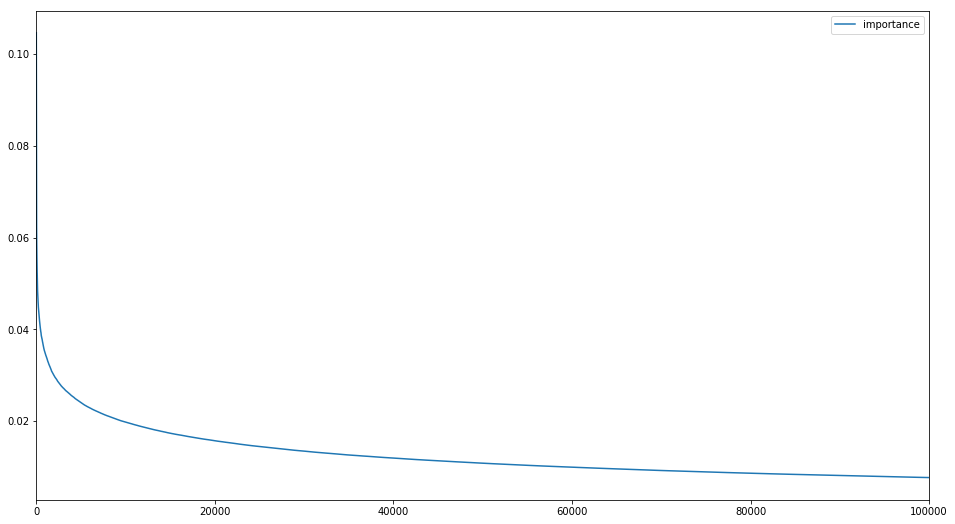

In [26]:
top_100k.plot(use_index=0, figsize=(16,9))
plt.show()

# Links in common with GENIE3

In [28]:
z_genie3 = pd.read_csv('/media/tmo/data/work/datasets/benchmarks/genie3/zeisel/zeisel.filtered.genie3.txt', header=None, sep='\t')
z_genie3.columns=['TF', 'target', 'importance']

In [29]:
inner = z_genie3.merge(top_100k, how='inner', on=['TF', 'target'])

In [30]:
len(inner)

89633

In [31]:
inner_50k = z_genie3[:50000].merge(top_100k[:50000], how='inner', on=['TF', 'target'])

In [32]:
len(inner_50k)

44269

In [33]:
inner_25k = z_genie3[:25000].merge(top_100k[:25000], how='inner', on=['TF', 'target'])

In [34]:
len(inner_25k) / 25000

0.87452

In [35]:
inner_10k = z_genie3[:10000].merge(top_100k[:10000], how='inner', on=['TF', 'target'])

In [36]:
len(inner_10k)

8487

In [37]:
inner_5k = z_genie3[:5000].merge(top_100k[:5000], how='inner', on=['TF', 'target'])

In [38]:
len(inner_5k)

4146